# Coursework: The Museum Protection Problem

## Import relevant libraries

In [1]:
import numpy as np
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import array
import csv
from operators import my_crossover, my_mutation

# import deap packages required
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

## Set up  

Depending on the instance you are trying to solve, sest the following parameters


In [2]:
# Windows and Mac: just set the path to the instance
myinst="Instances\WNMScotlandFloor5Left_5_cameras.csv"
instance_file = myinst  # the name of the file specifying the layout - use "" to represent an empty grid to an empty grid

#  COLAB: upload the instance to colab and
# instance_file = "./name_of_instance_file"

nb_cameras = 5 # number of cameras (specificed in the instance definition)
instance_size  = 100 # number of cells per dimension, i.e total number of cells in the grid is instance_size*instance_size

num_cells = instance_size*instance_size # total number of cells in the grid



In [3]:

# create a grid that specifies the walls that can be used later to check that no cameras are positioned on walls

walls = np.zeros(instance_size*instance_size)


with open(myinst) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for line in csv_reader:
        column=int(line[0])
        row=int(line[1])
        oneD_index = (row * instance_size) + column;
        walls[oneD_index]=1

## Set up the fitness calculations 

This calls an external executable to return a fitness value. You cannot modify the code in this executable. 


2. **If you are running on Windows using Anaconda, then your code needs to call the executables "bit_cam_napier_windows.exe" and "bit_cam_napier_visualisation_windows.exe" - you need to specify the exact path to these on your system in the code below**

The call to the external function is wrapped inside an evaluation function called **eval_function()** .. this has the standard form used by DEAP and should be registered with the toolbox as usual. Read the following carefully.    You can use any code you wish inside this function but it must always call the external *objective_function()* with a valid solution. This is defined below


 - The external "objective_function" needs to be passed a list of length (where n is the number of cells) where each value is 0 or 1.
- There must be exactly c values set to 1, where c= number of cameras
- Regardless of the representation you use, **you must turn a DEAP individual into a list of the form specified above** before calling the objective_function


**WARNING!!! You should only call the *objective_function* with a list that has exactly *c* bits set to 1**

If this is not the case, then you should assign a fitness value to the individual without calling the external  *objective_function*. You can choose how to set this - the fitness you assign should reflect the fact that the solution is invalid.  For a valid solution, the worst possible fitness is equal to *num_cells*, i.e. no cell is covered. Therefore, the fitness you choose to assign to an invalid solution should be worse than this value

In [4]:

# set the correct binary depending on your machine/setup - you need to choose one of the options below and set the path correctly

# On Windows: change the following to the location of the binary on your system
path_binary = r"C:\Users\Stephen\Desktop\ECO_CW\CourseworkExecutables\bit_cam_napier_windows.exe"
path_binary_vis = r"C:\Users\Stephen\Desktop\ECO_CW\CourseworkExecutables\bit_cam_napier_visualisation_windows.exe"

# Do NOT modify this code - this calls an external binary with a solution
def objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary,str(instance_size),str(nb_cameras)]+params+[instance_file]
    s = subprocess.check_output(cmd)
    return float(s)


# Do NOT modify: this checks whether a camera is positioned on top of wall in a solution
def check_walls(solution, inst):
    clashes=0
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i]==1):
            clashes+=1
            
    return(clashes)

In [5]:
def place_cameras(camera_positions):
    #print(camera_positions)
    grid = [0 for x in range(num_cells)]

    for p in camera_positions:
        try:
            grid[p] = 1
        except:
            print('p', p)
            print(camera_positions)
            grid[p] = 1


    return grid

In [6]:
# this is the eval function called from DEAP: you can modify this to adapt the fitness for invalid solutions. The fitness of a valid solution
# is obtained by calling the binary executable

# This is the function where you will likely do most work!

def eval_function(individual):

  solution=[]

  # The fitness function needs to be passed a list of length n (where n is the number of cells) 
  # where each value is 0 or 1. You must first convert
  # the individual passed to this function (a class) to a list

  # This code assumes your representation of an individual contains a 
  # list of 0,1s and is of length num_cells
  # If you have used another representation, you must write your own code to convert it to the form above
  #for i in range(0, len(individual)):
    #solution.append(individual[i])
  
  # 5 integer representation conversion
  solution = place_cameras(individual)
  
  # check how many cameras in the solution - if it does not equal nb_cameras the solution is *invalid*
  # if there are cameras placed on a wall, the solution is also invalid
  # if the solution is invalid, you must decide what fitness to 
  # assign - do *not* call the objective_function
  

  #total_cameras = np.sum(solution)
  total_cameras = len(individual)

  if instance_file == "":
    cameras_on_walls = 0
  else:
    cameras_on_walls = check_walls(solution, instance_file) 
            
                                        
# you will need to modify this code before you can run it
  if  total_cameras > nb_cameras:
    print(solution, len(solution), total_cameras, nb_cameras)
    #print('more than nb_cameras cameras', individual)

    fitness = num_cells # you decide!!!!
  elif total_cameras < nb_cameras:
    #print('less than nb_cameras cameras', individual)
    fitness = num_cells # you decide!!

  elif cameras_on_walls > 0:
    #print(f'{cameras_on_walls} on walls')
    fitness = num_cells # you decide!

  else:
    # only call this if the solution contains exactly nb_cameras and no cameras on walls,
    fitness = objective_function(solution, instance_size, nb_cameras, instance_file)
  return fitness,

## Set up the DEAP toolbox

This sets up a  very basic EA. It uses standard operators to manipulate a list of 0,1s.  You can change these operators for others from the DEAP toolbox or write your own

In [7]:

# define the fitness class and creare an individual class - set up as a minimisation problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) 
creator.create("Individual", list, fitness=creator.FitnessMin)

# create a toolbox
toolbox = base.Toolbox()

def smart_int_init():
    return random.randint(0, 9999)


# Define an individual as a list with each value set to 0 or 1, of length num_cells
# Attribute generator
toolbox.register("attr_bool", smart_int_init)

#an individual consists of repeated genes of type "attr_bool"  - we specify num_cells genes
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, nb_cameras)

#  a population consist of a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# register all operators we need with the toolbox
toolbox.register("evaluate", eval_function)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
#toolbox.register("mutate", tools.mutUniformInt, low=0, up=200, indpb=0.05)
toolbox.register("mutate", my_mutation.move_mutate, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=2)



In [8]:
# main function - this just uses a simple EA - you can modify as you wish, including xhanging the parameters

# default parameters
ngen=200
popsize=100
cxpb=1.0
mutpb=0.05

def main(ngen=ngen, popsize=popsize, cxpb=cxpb , mutpb=mutpb):

    # choose a population size: e.g. 50
    pop = toolbox.population(n=popsize)

    # keep track of the single best solution found
    hof = tools.HallOfFame(1)

    # create a statistics object: we can log what ever statistics we want using this. We use the numpy Python library
    # to calculate the stats and label them with convenient labels
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # run the algorithm: we need to tell it what parameters to use
    # cxpb = crossover probability; mutpb = mutation probability; ngen = number of iterations
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen,
                                   stats=stats, halloffame=hof, verbose=True)

    return pop, log, hof

# Experimenting

This runs the basic EA once. You can adapt this to run repeated expts. etc.

In [9]:
##############################
# run the main function
pop, log, hof = main()\

##############################


best = hof[0].fitness.values[0]   # best fitness found is stored at index 0 in the hof list


# look in the logbook to see what generation this was found at

min_lst = log.select("min")  # min fitness per generation stored in log

for i in range(ngen):  # set to ngen
        fit = min_lst[i]
        if fit == best:
            break

print("max fitness found is %s at gen %s " % (best, i))
print("number of cameras is %s" % (np.sum(hof[0])))

gen	nevals	avg   	std    	min 	max  
0  	100   	4725.9	1673.89	2600	10000
1  	100   	4017.82	686.2  	2112	5833 
2  	100   	3874.7 	665.714	2495	6157 
3  	100   	3801.61	636.736	2259	5392 
4  	100   	3657.36	711.745	2002	5567 
5  	100   	3482.89	624.789	2136	5097 
6  	100   	3281.72	673.042	2115	5558 
7  	100   	3234.47	727.578	1972	5931 
8  	100   	3223.03	665.648	1957	4648 
9  	100   	3170.11	624.769	1948	4948 
10 	100   	3067.48	926.572	1914	10000
11 	100   	2791.15	535.802	1667	4765 
12 	100   	2685.68	473.238	1948	4179 
13 	100   	2605.8 	427.198	1948	3890 
14 	100   	2423.67	325.291	1948	3365 
15 	100   	2253.48	217.829	1906	2820 
16 	100   	2143.33	190.009	1906	2757 
17 	100   	2099.62	200.368	1906	2923 
18 	100   	2011.07	89.1204	1906	2561 
19 	100   	1974.72	69.0635	1906	2502 
20 	100   	1948.06	22.9651	1906	2044 
21 	100   	1951.66	120.233	1906	3136 
22 	100   	1931.62	20.4855	1906	1948 
23 	100   	1924.03	63.3049	1743	2497 
24 	100   	1909.58	25.3133	1743	2060 
25 	100   	190

In [ ]:
if False:
    mutation_rate = [0.01, 0.03, 0.05, 0.07, 0.09, 0.5]
    repeat_runs = 5
    for r in mutation_rate:
            for i in range(repeat_runs):
                ##############################
                # run the main function
                pop, log, hof = main(mutpb=r)\

                ##############################


                best = hof[0].fitness.values[0]   # best fitness found is stored at index 0 in the hof list


                # look in the logbook to see what generation this was found at

                min_lst = log.select("min")  # min fitness per generation stored in log

                for i in range(ngen):  # set to ngen
                        fit = min_lst[i]
                        if fit == best:
                            break

                print("max fitness found is %s at gen %s " % (best, i))
                print("number of cameras is %s" % (np.sum(hof[0])))

                with open('mutation_rate_experiment.csv', 'a') as f:
                    f.write(str(r) + ',' + str(best) + ',' + str(i) + '\n')


## Plotting (optional)

C:\Users\Stephen\AppData\Local\Temp\ipykernel_34512\211261980.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
C:\Users\Stephen\AppData\Local\Temp\ipykernel_34512\211261980.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
C:\Users\Stephen\AppData\Local\Temp\ipykernel_34512\211261980.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")
C:\Users\Stephen\AppData\Local\Temp\ipykernel_34512\211261980.py:19: UserWarning: color is redundantly defin

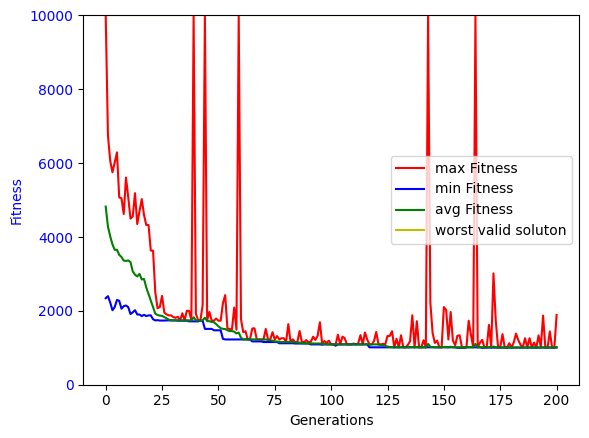

In [ ]:
# This is not necessary - but useful to see what is going on for a single run
# code for plotting

gen = log.select("gen")
fit_max = log.select("max")
fit_min = log.select("min")
fit_avg = log.select("avg")

fig, ax1 = plt.subplots()

# set this to the number of generations in the EA
my_gens=ngen
# add a line to indicate "valid solutions" i.e solutions with the correct number of cameras. Any solution below this line is valid
worst_valid = [num_cells]*(my_gens+1)

line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")
line4 = ax1.plot(gen, worst_valid, "b-", label="worst valid soluton", color="y" )
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")
    
plt.ylim(0,num_cells+10)   # change the scale on the graph to see the valid solutions better

lns = line1+line2+line3+line4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")



# Visualisation Tools

The code sets up some functions to allow you do visualise solutions. You shouldn't need to alter the code in the cell below (make sure the variable *path_binary_vis* is set to the correct binary at the start)



In [ ]:

# Run this cell to define the functions
def solution_converter(index, instance_size):
    counter = 0
    for i in range(instance_size):
        for j in range(instance_size):
            if (counter == index):
                return i,j
            else:
                counter+=1

# assumes path_binary is already set 
def visualise_objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    print(params)
    cmd = [path_binary_vis,str(instance_size),str(nb_cameras)]+params+[instance_file]
    print(cmd)
    with open("temp_results.csv",'w') as fd:
        s = subprocess.call(cmd, stdout=fd)
    # Plotting the probability of detection
    data = pd.read_csv("temp_results.csv")
    values = np.array(data["value"])
    values[values < 0.5] = 0
    values = values.reshape(instance_size,instance_size)
    plt.imshow(values,cmap="Reds")
    # Plotting cameras
    cameras_indices = [index for (index, item) in enumerate(list(x)) if item == 1]
    for c in cameras_indices:
        x,y = solution_converter(c, instance_size=instance_size)
        plt.scatter(y,x,c="blue",marker="D")
    # Plotting walls (if any)
    if (instance_file != ""):
        walls = pd.read_csv(instance_file,header=None)
        plt.scatter(walls[1],walls[0],c="black", marker="_")
    plt.xlim(0,instance_size-1)
    plt.xlabel("y")
    plt.ylim(0,instance_size-1)
    plt.ylabel("x")
    plt.show()
    


### Visualising a solution


[8078, 3387, 8319, 2819, 3058]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

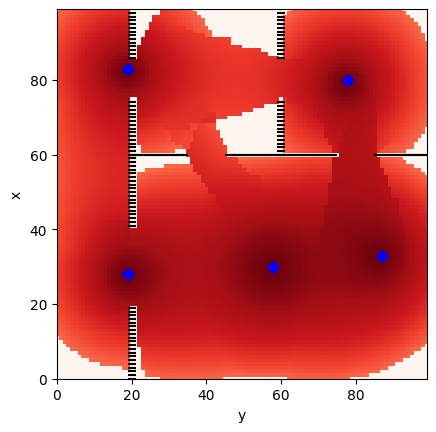

In [ ]:
# here we visualise the best result returned from the algorithm - it assumes an individual is a list of 0,1s. 
# If your individual uses a different representation then adapt accordingly to reshape into this form

# first we need to turn the individual returned into a list
best_solution=[]
for i in range(0, len(hof[0])):
    best_solution.append(hof[0][i])

print(best_solution)
sol = place_cameras(best_solution)
print(sol)

visualise_objective_function(sol, instance_size=instance_size, nb_cameras=5, instance_file=myinst)

## Hill Climbers

In [ ]:
def first_choice_hill_climber(individual):
    print("You don't wanna hurt me (yeah, yeah, yo)")

    current_best_ind = [x for x in individual]   # create a copy of the individuals solution
    current_best_fitness = eval_function(current_best_ind)[0]   # fitness of current best solution

    new_fitness = num_cells # stores fitness of newly created solutions

    move_range = 10
    mutation_prob = 0.2
    move_set_size = 1

    attempts_since_last_improvement = 0

    while attempts_since_last_improvement < 500:

        if attempts_since_last_improvement % 100 == 0:
            move_range -= 1
            print('attempst', attempts_since_last_improvement, move_range)
        #print(current_best_ind, current_best_fitness)

        # create a set of new solutions using move operator
        new_solutions = [my_mutation.move_mutate([x for x in current_best_ind], row_move_range=move_range, indpb=mutation_prob)[0] for x in range(move_set_size)]
        #print(new_solutions)

        # evaluate each solution
        new_solution_fitnesses = []
        for sol in new_solutions:
            new_solution_fitnesses.append(eval_function(sol)[0])
        #print(new_solution_fitnesses)

        # identify best from new solutions
        best_new_solution = new_solutions[new_solution_fitnesses.index(min(new_solution_fitnesses))]
        best_new_fitness = new_solution_fitnesses[new_solution_fitnesses.index(min(new_solution_fitnesses))]
        #print(best_new_solution, best_new_fitness)

        if best_new_fitness < current_best_fitness:
            attempts_since_last_improvement = 0
            current_best_ind = best_new_solution
            current_best_fitness = best_new_fitness
            print(current_best_fitness, current_best_ind)
            move_range = 10
        else:
            attempts_since_last_improvement += 1

    visualise_objective_function(place_cameras(current_best_ind), instance_size=instance_size, nb_cameras=5, instance_file=myinst)

In [ ]:
def generate_possible_single_camera_mutations(solution, max_move, grid_size=100):
    """
    Generate all possible mutations for a solution, moving only one camera at a time.

    :param solution: A list of 5 camera positions.
    :param max_move: The maximum movement range for a single camera.
    :param grid_size: The size of one dimension of the grid.
    :return: A list of all possible mutated solutions.
    """
    possible_mutations = []

    for i, current_position in enumerate(solution):
        # Generate possible moves for the current camera
        possible_moves = generate_possible_moves(current_position, max_move, grid_size)

        for new_position in possible_moves:
            # Create a new solution with the mutated position
            mutated_solution = solution.copy()
            mutated_solution[i] = new_position
            possible_mutations.append(mutated_solution)

    return possible_mutations

def generate_possible_moves(position, max_move, grid_size=100):
    possible_moves = []
    row, col = divmod(position, grid_size)

    for row_move in range(-max_move, max_move + 1):
        for col_move in range(-max_move, max_move + 1):
            new_row = max(0, min(row + row_move, grid_size - 1))
            new_col = max(0, min(col + col_move, grid_size - 1))
            new_position = new_row * grid_size + new_col

            if new_position != position:  # Exclude the current position
                possible_moves.append(new_position)

    possible_moves = list(dict.fromkeys(possible_moves)) # remove duplicates

    return possible_moves

40
970.0 [8078, 3387, 8319, 2720, 3058]
40
952.0 [8078, 3387, 8320, 2720, 3058]
40
941.0 [8179, 3387, 8320, 2720, 3058]
40
932.0 [8179, 3387, 8320, 2620, 3058]
40
924.0 [8179, 3288, 8320, 2620, 3058]
40
920.0 [8179, 3189, 8320, 2620, 3058]
40
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '

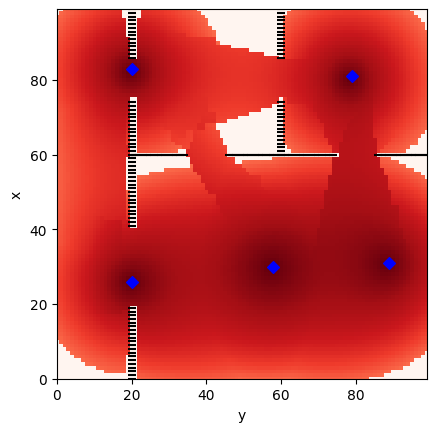

In [ ]:
def steepest_ascent_hill_climber(individual):
    evals_used = 0

    current_best_ind = [x for x in individual]   # create a copy of the individuals solution
    current_best_fitness = eval_function(current_best_ind)[0]   # fitness of current best solution

    move_range = 1

    improvement_made = True

    while improvement_made:

        #print(current_best_ind, current_best_fitness)

        # create a set of new solutions using move operator
        new_solutions = generate_possible_single_camera_mutations(current_best_ind, move_range)
        print(len(new_solutions))

        # evaluate each solution
        new_solution_fitnesses = []
        for sol in new_solutions:
            new_solution_fitnesses.append(eval_function(sol)[0])
            evals_used += 1
        #print(new_solution_fitnesses)

        # identify best from new solutions
        best_new_solution = new_solutions[new_solution_fitnesses.index(min(new_solution_fitnesses))]
        best_new_fitness = new_solution_fitnesses[new_solution_fitnesses.index(min(new_solution_fitnesses))]
        #print(best_new_solution, best_new_fitness)

        if best_new_fitness < current_best_fitness:
            current_best_ind = best_new_solution
            current_best_fitness = best_new_fitness
            print(current_best_fitness, current_best_ind)
        else:
            improvement_made = False

    visualise_objective_function(place_cameras(current_best_ind), instance_size=instance_size, nb_cameras=5, instance_file=myinst)

40
991.0 [8078, 3288, 8319, 2819, 3058]
40
990.0 [8078, 3288, 8319, 2819, 3057]
40
987.0 [8078, 3288, 8219, 2819, 3057]
40
974.0 [8078, 3187, 8219, 2819, 3057]
40
972.0 [8078, 3187, 8219, 2719, 3057]
40
966.0 [8078, 3187, 8120, 2719, 3057]
40
958.0 [8079, 3187, 8120, 2719, 3057]
40
950.0 [8079, 3187, 8120, 2619, 3057]
40
941.0 [8079, 3187, 8120, 2619, 3157]
40
940.0 [8079, 3187, 8120, 2519, 3157]
40
938.0 [8179, 3187, 8120, 2519, 3157]
40
936.0 [8179, 3088, 8120, 2519, 3157]
40
926.0 [8179, 3088, 8120, 2420, 3157]
40
924.0 [8179, 3089, 8120, 2420, 3157]
40
923.0 [8179, 2988, 8120, 2420, 3157]
40
919.0 [8179, 2988, 8120, 2320, 3157]
40
917.0 [8179, 2988, 8120, 2320, 3257]
40
912.0 [8179, 2889, 8120, 2320, 3257]
40
903.0 [8179, 2889, 8120, 2320, 3358]
40
899.0 [8179, 2889, 8120, 2320, 3359]
40
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '

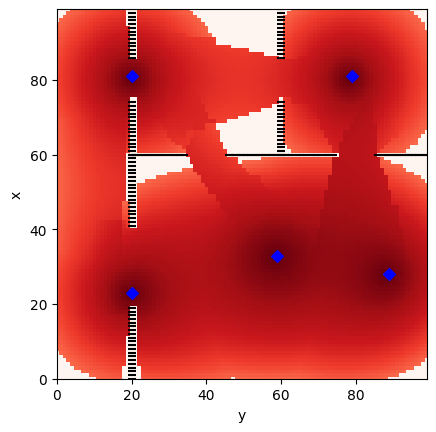

In [ ]:
def stochastic_hill_climber(individual):

    current_best_ind = [x for x in individual]   # create a copy of the individuals solution
    current_best_fitness = eval_function(current_best_ind)[0]   # fitness of current best solution

    move_range = 1

    attempts_since_last_improvement = 0
    improvement_made = True

    while improvement_made:

        #print(current_best_ind, current_best_fitness)

        # create a set of new solutions using move operator
        new_solutions = generate_possible_single_camera_mutations(current_best_ind, move_range)
        print(len(new_solutions))

        # evaluate each solution
        new_solution_fitnesses = []
        for sol in new_solutions:
            new_solution_fitnesses.append(eval_function(sol)[0])
        #print(new_solution_fitnesses)

        # get the indexes of the better solutions
        better_solution_fitness_indexes = []
        for i in range(len(new_solution_fitnesses)):
            if new_solution_fitnesses[i] < current_best_fitness:
                better_solution_fitness_indexes.append(i)

        if len(better_solution_fitness_indexes) == 0:
            improvement_made = False
            break

        # randomly choose from better solutions
        random_better_index = random.choice(better_solution_fitness_indexes)
        better_new_solution = new_solutions[random_better_index]
        better_new_fitness = new_solution_fitnesses[random_better_index]
        #print(best_new_solution, best_new_fitness)

        if better_new_fitness < current_best_fitness:
            current_best_ind = better_new_solution
            current_best_fitness = better_new_fitness
            print(current_best_fitness, current_best_ind)
        else:
            improvement_made = False

    visualise_objective_function(place_cameras(current_best_ind), instance_size=instance_size, nb_cameras=5, instance_file=myinst)

In [ ]:

best_ind = [x for x in hof[0]]
current_best = eval_function(best_solution)[0]
new_fitness = num_cells
print(current_best)

mutation_range = 10
mutation_prob = 0.2 

for i in range(100):

    mutations = 0

    # while a better fitness hasn't been found
    while new_fitness >= current_best:

        # mutate the current best solution
        mutated_ind = my_mutation.move_mutate([x for x in best_ind], row_move_range=mutation_range, indpb=mutation_prob)[0]
        new_fitness = eval_function(mutated_ind)[0]

        mutations += 1
        if mutations % 100 == 0:
            print(mutations)
            
        if mutations == 1000:
            print('no better found after 1000 mutations, increasing mutation')
            mutation_prob += 0.1
            print(mutation_prob, mutation_range)

            mutated_ind = best_ind
            new_fitness = current_best
            break


    best_ind = mutated_ind
    current_best = new_fitness
    print(current_best)

    if mutation_prob >= 0.5:
        break

visualise_objective_function(place_cameras(best_ind), instance_size=instance_size, nb_cameras=5, instance_file=myinst)

In [ ]:
if False:
    #mutated_ind = move_mutate([x for x in hof[0]])
    mutated_ind = move_mutate(hof[0])

    mutated_solution=[]
    for i in range(0, len(mutated_ind)):
        mutated_solution.append(mutated_ind[i])

    print(mutated_solution[0])
    sol = place_cameras(mutated_solution[0])
    print(sol)

    visualise_objective_function(sol, instance_size=instance_size, nb_cameras=5, instance_file=myinst)

In [ ]:
print(hof[0])

[8078, 3387, 8319, 2819, 3058]
